<a href="https://colab.research.google.com/github/jegraham/Thesis_Testing/blob/NON-GNN_Phase1/Graham%2C_Jessica_Non_GNN_Clustering_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-GNN Implementation (Phase 1)

This is the initial Non-GNN Clustering Implementation


## Import

### Import Libraries

In [5]:
import os
import os.path as osp
import shutil # -> For copying a directory
import pandas as pd # -> For data structure and file manipulation
import random

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [6]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

#!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
#print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install scikit-learn
#!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html



import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
from scipy.spatial.distance import cdist, squareform
from sklearn.cluster import KMeans, MeanShift, AffinityPropagation, FeatureAgglomeration, SpectralCoclustering, MiniBatchKMeans, Birch, DBSCAN, OPTICS, AgglomerativeClustering, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, InMemoryDataset, download_url
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GAE
from torch_geometric.utils import train_test_split_edges, from_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit
import torch.nn.functional as F


2.0.1+cu118
Using cuda.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Check GPU

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 27 23:22:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check Memory

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [9]:
# Import the Data
from google.colab import files
uploaded = files.upload()
# uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

file_name = next(iter(uploaded))
print(file_name)
df = pd.read_csv(file_name)
df = df.reset_index(drop=True)

Saving May 4th Dataset Car and Tower  - Sheet1 (1).csv to May 4th Dataset Car and Tower  - Sheet1 (1).csv
May 4th Dataset Car and Tower  - Sheet1 (1).csv


## Setup


### Setup Dataset


In [39]:
# Generate a graph
# Inspirations taken from - Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

# Create an empty graph and lists
G = nx.Graph()
edge_index = []


# iterate through rows and add nodes to the graph
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])


# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'], errors='coerce')

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor


# add nodes to the graph with their features
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

# Loop row by row to add the edges to the graph
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)):
        if i == j:
            continue

        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)

        if 0 < dist <= 500:
          distances.append((dist, j))
        # print(distance)

   distances.sort()

   for k in range(len(distances)):
       G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)


[(0, 276), (0, 6), (0, 190), (0, 237), (0, 198), (0, 275), (0, 269), (0, 59), (0, 166), (0, 142), (0, 256), (0, 131), (0, 90), (0, 60), (0, 228), (0, 221), (0, 149), (0, 137), (0, 86), (0, 70), (0, 291), (0, 25), (0, 67), (0, 85), (0, 83), (0, 26), (0, 51), (0, 267), (1, 12), (1, 57), (1, 250), (1, 225), (1, 183), (1, 79), (1, 27), (1, 235), (1, 8), (1, 174), (1, 105), (1, 247), (1, 173), (1, 99), (1, 47), (1, 53), (1, 207), (1, 62), (1, 39), (1, 245), (2, 178), (2, 293), (2, 159), (2, 124), (2, 265), (2, 309), (2, 44), (2, 14), (2, 263), (2, 261), (2, 156), (2, 220), (2, 17), (2, 157), (2, 253), (2, 249), (2, 117), (2, 209), (2, 298), (2, 76), (2, 103), (2, 187), (2, 23), (2, 289), (2, 177), (2, 128), (2, 301), (2, 55), (2, 91), (2, 122), (2, 78), (2, 61), (2, 162), (2, 163), (2, 260), (2, 134), (2, 274), (3, 243), (3, 75), (3, 303), (3, 214), (3, 116), (3, 255), (3, 112), (3, 41), (3, 72), (3, 155), (3, 239), (3, 73), (3, 296), (3, 95), (3, 223), (3, 37), (3, 252), (4, 229), (4, 136)

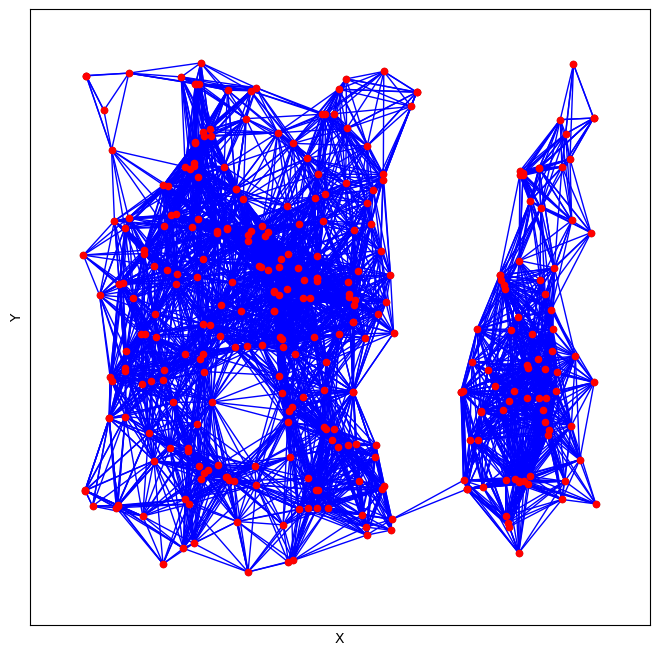

In [40]:
# Plotting Graph (Version 1)
X = df[['X', 'Y']].values

# create a layout for the graph nodes
pos = dict(zip(range(len(df)), X))

# draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['X'], df['Y'], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='b', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()


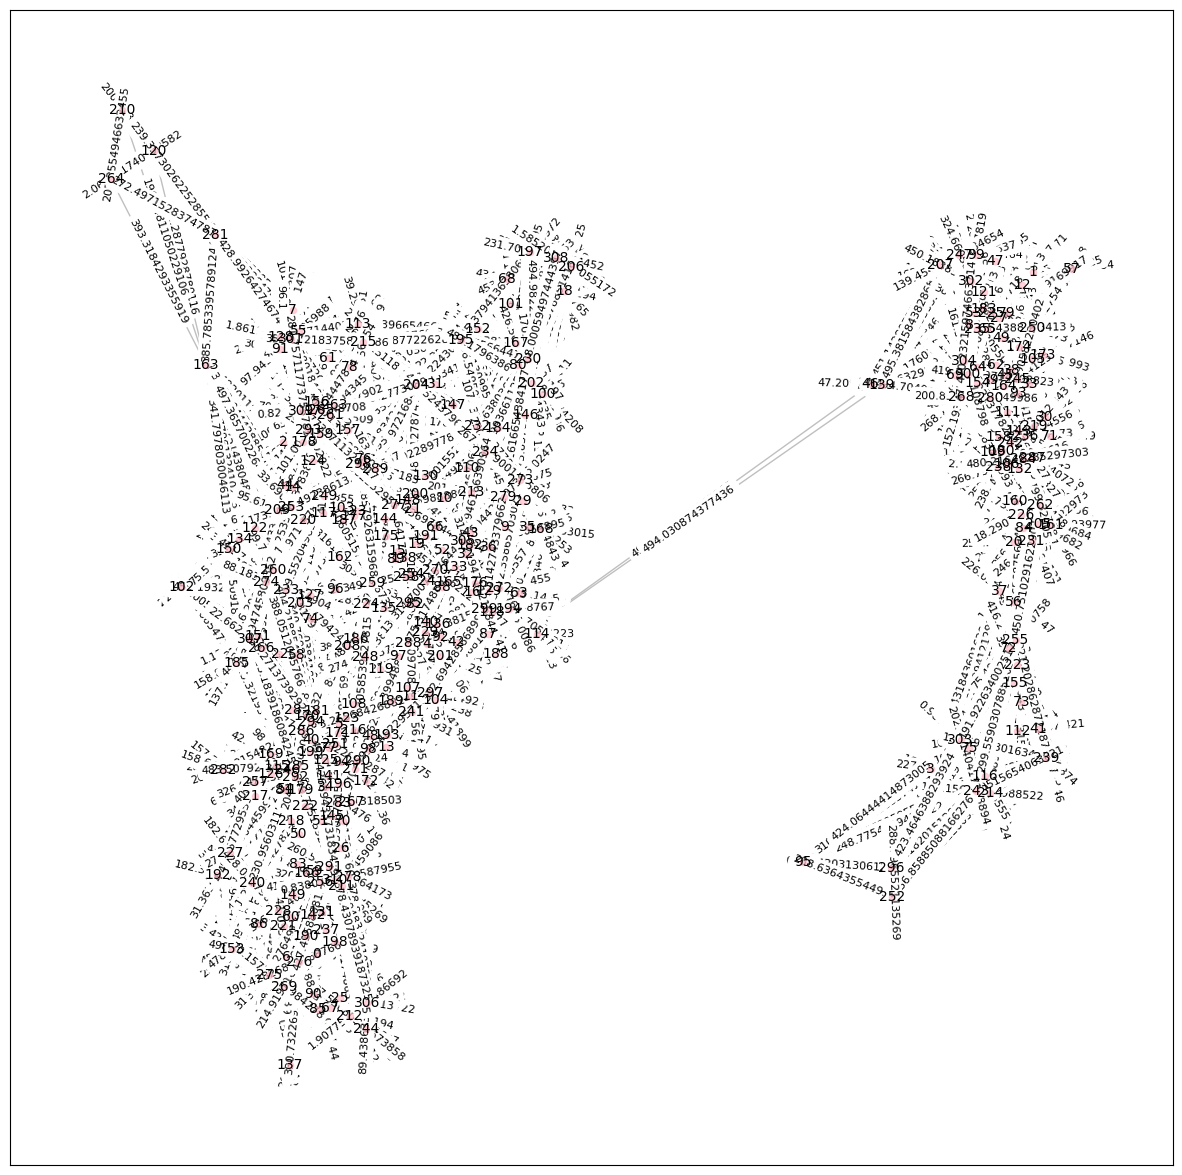

In [41]:
# Plotting Graph (Version 2)

# generate a layout for the graph nodes
pos = nx.spring_layout(G, k=1.1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))


# draw the nodes of the graph
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='pink', alpha=0.7, edgecolors='pink')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# draw the edges of the graph
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# get the edge weights as a dictionary
edge_labels = nx.get_edge_attributes(G, 'weight')

# draw the edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# display the graph

plt.show()

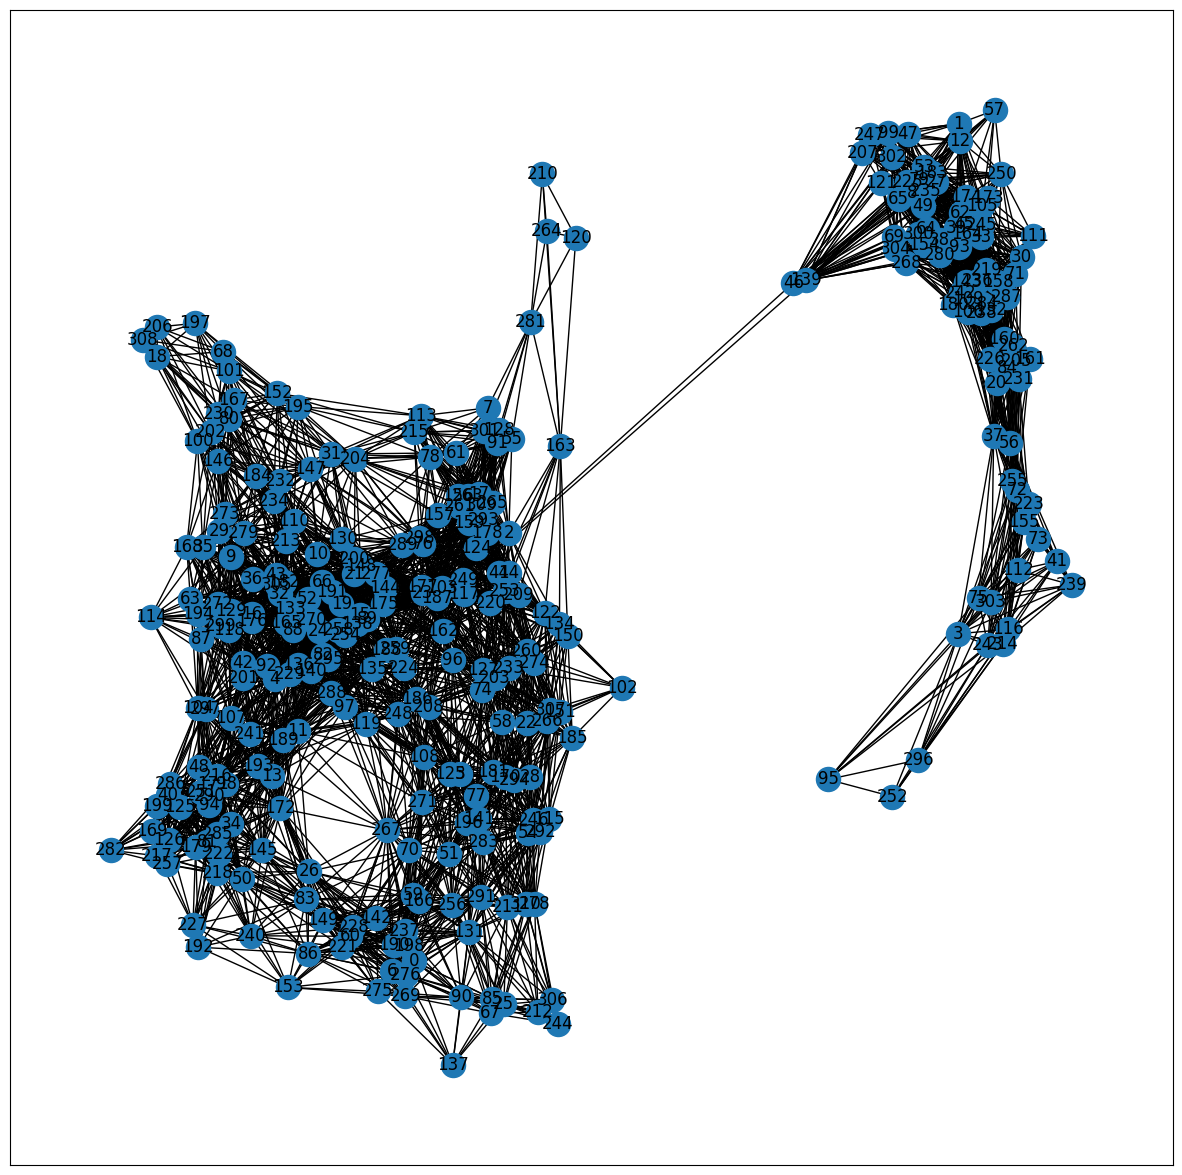

Graph with 311 nodes and 4994 edges


In [42]:
# Plotting Graph (Version 3)
# Displaying the Graph Edges Similar

# specify node positions
pos = nx.spring_layout(G,k=1, iterations=50, seed=42)
fig, ax = plt.subplots(figsize=(15, 15))

# draw nodes
nx.draw_networkx_nodes(G, pos)

# draw node labels
nx.draw_networkx_labels(G, pos)

# draw edges
nx.draw_networkx_edges(G, pos)


plt.show()

print(G)

## Approaches (Non-GNN)
 Use of https://scikit-learn.org/stable/modules/clustering.html#k-means


### Comparison Parameters



* **Density** - Number of vehicles over the square unit
* Avg Direction
* Signal Strength
* Percent Changed over time
* Elapsed Time
* Intervals of time
* Time to execute
* Cluster size / Avg Cluster Size
* No. of Vehicles
* Avg No. Hops
* Avg Distance from Infrastructure
* Cluster Head Distance from Infrastructure
* Dwell Time

### Display Parameters
https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

In [45]:
# k = 2
K = range(1,10) # KMeans
clusters_num = 8 # This represents the number of clusters - KMeans, Spectral, Split and Merge,
n = 10 # This is the value used for n_init which is the number of runs - KMeans, Spectral, Split and Merge,
batch_size = 100

# Get the adjacency matrix of the graph
A = nx.adjacency_matrix(G).todense()

# Define node colors based on the clusters (-1 represents outliers)
clusters = [1]
colors = ['black' if c == -1 else 'blue' if c == 0 else 'g' if c == 1 else 'r' if c == 2 else 'y' if c == 3 else 'm' if c == 4 else 'm' if c == 5 else 'brown' if c == 6 else 'lightgreen' if c == 7 else 'fuchsia' if c == 8 else 'coral' if c == 9 else 'cornflowerblue' if c == 10 else 'orchid' if c == 11 else 'mediumspringgreen' if c == 12 else 'turqoise' if c == 13 else 'orange' for c in clusters]

# TO DO
# - How does .fit(A) differ from .fit(embeddings)?
# k vs clusters_nums parameter
# Testing parameters for analysis - Dwell time, avg distance, computation time, avg # hops, density, avg direction, signal strength, percent change
# Analysis based on iterations of time, how do they differ based on the vehicles next movements?
# Additional Clusters to review: V-Cluster, Vehicular Fuzzy Clustering, Clustering Algorithm for connected Autonomous Vehicles (CACCA) Multi-Objective Vheiculer Clustering Algorithm (MVCA), Vehicular Clustering Algorithm with Mobility Prediction (VCA-M, HIerarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN), Subspace Clustering (SUBCLU), Shared Nearest Neighbour-Clustering with Quality (SNN-Ciq), COBWEB-X, Clustering Using representatives and shrinkage (CURE-S), Spherical k-means

### K-Means (Non-GNN)
This approach comes from Nazanin's Github. The K-Means takes the number of clusters as a parameter and organizes accordingly.

This is a traditional approach that has been used to cluster vehicles that aims to minimize the within-cluster sum of squares (WCSS) or the sum of squared distances between objects and their centroid.

This approach does have limitations with managing clusters with varying sizes in desnities. We are looking to balance the sizes and densities of our clusters to evenly distribute the resources.

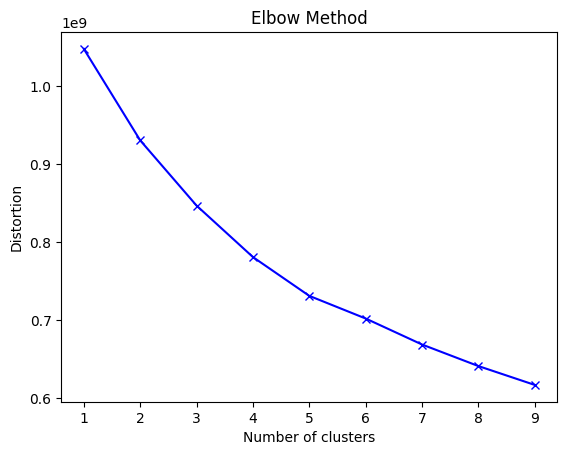

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


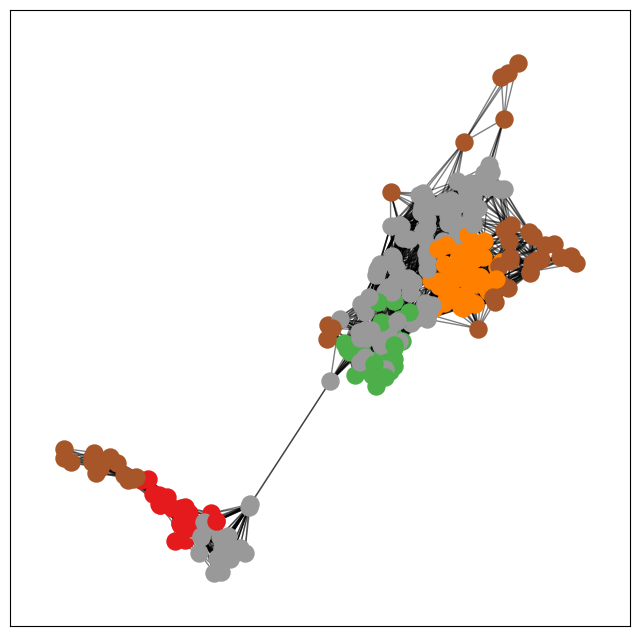

In [46]:
# Determine the optimal number of clusters using the elbow method
distortions = []

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=n).fit(A)
    distortions.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()


# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=150, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Spectral (Non-GNN)

This approach comes from Nazanin's Github. The Spectral is based off of eigenvectors or spectrumof a similarity matrix or graph Laplacian.

This is a traditional approach that has been used to cluster vehicles is a combnination of graph theory, linear algebra, and clustering to determine low-dimensional embeddings.  This algorithm is best known for it's ability to handle limited linear separability. It takes in the number of clusters as a parameter. By looking at data point similarities and graphing. Eigenvectors determines the underlying structure of clusters through the low-frequency data components.

This approach does have limitations with noisy data resulting in incorrect assignments due to outliers. Similar to K-Means this algorithm also experiences challenges with varying densities as it favours compact densities.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


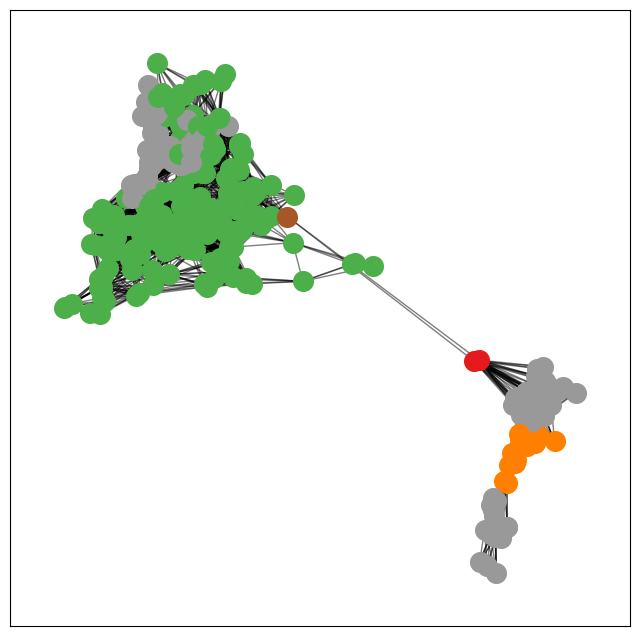

In [47]:
# Compute the Laplacian matrix
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=1))
L = D - A

# Compute the eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eig(L)

# Sort the eigenvalues and corresponding eigenvectors in ascending order
idx = eigenvalues.argsort()
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

# Use the first two eigenvectors to create the embedding matrix
embedding = np.column_stack((eigenvectors[:,0], eigenvectors[:,1]))

# Apply K-means clustering on the embedding matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(embedding)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Split and Merge
[Paper Citation](https://dl-acm-org.proxy.library.brocku.ca/doi/abs/10.1145/3479243.3487307)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


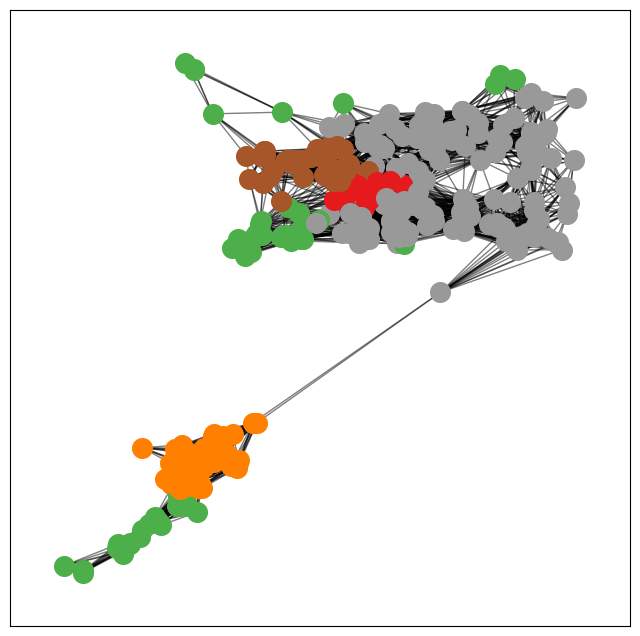

In [48]:
def split_method(cList, sList, k, theta):
    ssemax = max([SSE(c, s) for c in cList for s in sList])
    cList_hat = cList.copy()
    sList_hat = sList.copy()

    if ssemax > theta:
        ssemax_id = np.argmax([SSE(c, s) for c in cList for s in sList])
        SplitS = sList_hat.pop(ssemax_id)
        cList_hat.pop(ssemax_id)
        newC = kmeans(Kmax=2, data=SplitS)
        cList_hat.add(newC.cList)
        sList_hat.add(newC.sList)
        k_hat = k + 1
        return cList_hat, sList_hat, k_hat
    else:
        return cList_hat, sList_hat, k

def merge_method(cList, sList, beta, mk, path):
    ssemin = min([SSE(c, s) for c in cList for s in sList])

    if ssemin < beta and SSEmin > mk:
        ssemin_id = np.argmin([SSE(c, s) for c in cList for s in sList])
        C = cList[ssemin_id]
        S = sList[ssemin_id]
        for s in S:
            A = predict(s, cList, path)
            cList[A].add(s)
        k_hat = k - 1
        return cList, k_hat
    else:
        return cList, k

def SSE(c, s):
    # calculate SSE between cluster c and subset s
    pass

def kmeans(Kmax, data):
    kmeans = KMeans(n_clusters=Kmax)
    newC = kmeans.fit(data)
    return newC

def predict(Switch, cList, path):
    distance = [path[Switch][c] for c in cList]
    indxc = np.argmin(distance)
    sList[indxc].add(Switch)
    cList[indxc].load += Switch.load
    return indxc


# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num, n_init=n).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_


# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Affinity Propagation

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


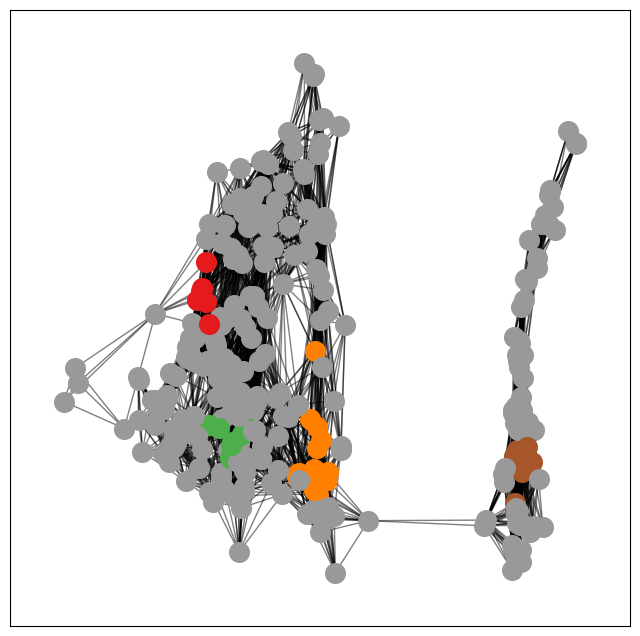

In [49]:
# Compute the similarity matrix using negative Euclidean distances
S = -pairwise_distances(A, metric='euclidean')

# Perform Affinity Propagation clustering
aff_prop = AffinityPropagation().fit(S)

# Get the cluster labels
clusters = aff_prop.labels_


# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Mean Shift

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


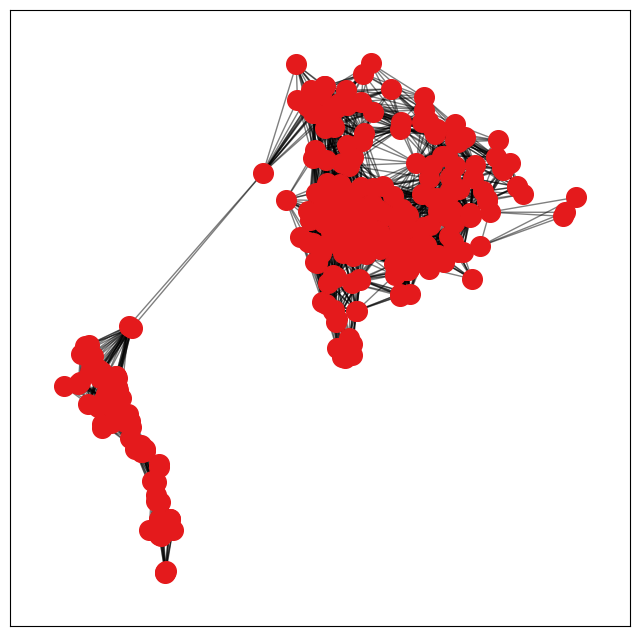

In [50]:
# Compute the similarity matrix using negative Euclidean distances
S = -pairwise_distances(A, metric='euclidean')

# Perform Mean Shift clustering
mean_shift = MeanShift().fit(S)

# Get the cluster labels
clusters = mean_shift.labels_


# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Ward Hierarchical

Needs work as node 311 is not appearing??

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


NetworkXError: ignored

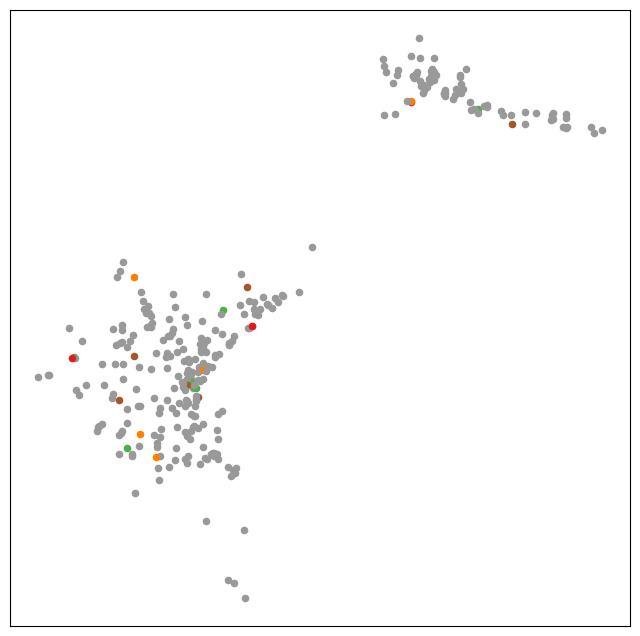

In [56]:
# Compute the pairwise distance matrix
dist_matrix = squareform(A)

# Convert to a 2D day
dist_matrix = dist_matrix.reshape(-1, 1)

# Perform Ward hierarchical clustering
ward = AgglomerativeClustering(n_clusters=clusters_num, linkage='ward', affinity='euclidean').fit(dist_matrix)

# Get the cluster labels
clusters = ward.labels_

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=20, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Agglomerative

In [ ]:
# Run K-means clustering on the adjacency matrix
kmeans = KMeans(n_clusters=clusters_num).fit(A)

# Assign the nodes to the corresponding clusters
clusters = kmeans.labels_

# Perform Agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=clusters_num, affinity='euclidean', linkage='ward').fit(A)

# Get the cluster labels
clusters = agglomerative.labels_

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Ordering Points To Identify the Clustering Structure (OPTICS)

In [ ]:
# Convert the adjacency matrix to a distance matrix
dist_matrix = np.sqrt(2 * (1 - A))

# Impute missing values
imputer = SimpleImputer(strategy='mean')
A_imputed = imputer.fit_transform(A)

# Convert the imputed adjacency matrix to a distance matrix
dist_matrix = np.sqrt(2 * (1 - A_imputed))

# Perform OPTICS clustering
optics = OPTICS(min_samples=clusters_num, xi=0.05, min_cluster_size=0.1)
optics.fit(A)

# Get the cluster labels
clusters = optics.labels_

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Guassian Mixtures (GMM)

In [ ]:
# Run Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=2)
gmm.fit(A)

# Assign the nodes to the corresponding clusters
clusters = gmm.predict(A)

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)

In [ ]:
# Run BIRCH clustering
birch = Birch(n_clusters=clusters_num)
birch.fit(A)

# Assign the nodes to the corresponding clusters
clusters = birch.predict(A)

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Bi-Secting K-Means

Not executing error

In [60]:
# Define the Bi-Secting K-Means function
def bi_secting_kmeans(X, k):
    clusters = []
    clusters.append(X)  # Start with the entire dataset as one cluster

    while len(clusters) < k:
        sse = []
        for cluster in clusters:
            kmeans = KMeans(n_clusters=clusters_num, n_init=n)
            kmeans.fit(cluster)
            sse.append(kmeans.inertia_)  # Compute SSE for each cluster

        # Find the cluster with the maximum SSE and split it into two
        max_sse_cluster_idx = np.argmax(sse)
        max_sse_cluster = clusters[max_sse_cluster_idx]
        kmeans = KMeans(n_clusters=clusters_num, n_init=n)
        kmeans.fit(max_sse_cluster)
        subclusters = kmeans.predict(max_sse_cluster)

        # Update the cluster list
        clusters.pop(max_sse_cluster_idx)
        clusters.append(max_sse_cluster[subclusters == 0])
        clusters.append(max_sse_cluster[subclusters == 1])

    return clusters

# Get the adjacency matrix of the graph
A = nx.adjacency_matrix(G).todense()

# Run Bi-Secting K-Means clustering
clusters = bi_secting_kmeans(A, clusters_num)

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

ValueError: ignored

### DBSCAN

In [ ]:
# Convert the adjacency matrix to a distance matrix
dist_matrix = np.sqrt(2 * (1 - A))

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
dbscan.fit(A)

# Get the cluster labels
clusters = dbscan.labels_

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Spectral Co-Clustering

In [ ]:
spectral_coclustering = SpectralCoclustering(n_clusters=clusters_num)

# Fit the data to the model
spectral_coclustering.fit(A)

# Get the row and column labels assigned to each cluster
row_labels = spectral_coclustering.row_labels_
column_labels = spectral_coclustering.column_labels_

# Print the cluster labels for each row and column
print("Row Labels:")
print(row_labels)
print("Column Labels:")
print(column_labels)

# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Mini Batches K-Means

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=clusters_num, batch_size=batch_size)

# Fit the data to the model
kmeans.fit(A)

# Get the cluster labels for the data points
labels = kmeans.labels_

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Print the cluster labels and centroids
print("Cluster Labels:")
print(labels)
print("Cluster Centroids:")
print(centroids)


# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Feature Agglomeration

In [ ]:
agglo = FeatureAgglomeration(n_clusters=clusters_num)

# Fit the data to the model and transform it
transformed_data = agglo.fit_transform(A)

# Print the shape of the transformed data
print("Transformed Data Shape:", transformed_data.shape)


# Plot Graph with Clusters
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
for i, cluster in enumerate(clusters):
    color = plt.cm.Set1(cluster / 4.)
    nx.draw_networkx_nodes(G, pos, [i], node_size=200, node_color=color)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()